# Decision Tree Model for Diabetes Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## 1. Data Acquisition

In [2]:
df = pd.read_csv("./TAIPEI_diabetes.csv",sep=",",index_col="PatientID")
df.shape

(15000, 9)

## 2. Data Preparation

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# Split data into training and testing sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
# Display training data shape
df_train.shape

(12000, 9)

In [6]:
# Define feature columns for clarity
feature_columns = ['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure',
                   'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age']

In [7]:
# Extract features and target for training data
X_train = df_train.loc[:, feature_columns].values
y_train = df_train.Diabetic.values

In [8]:
# Extract features and target for test data
X_test = df_test.loc[:, feature_columns].values
y_test = df_test.Diabetic.values

## 3. Decision Tree Model Implementation

In [9]:
from sklearn.tree import DecisionTreeClassifier

# Initialize decision tree classifier
dt_classifier = DecisionTreeClassifier(max_depth=5, random_state=42)

# Train the model
dt_classifier.fit(X=X_train, y=y_train)

# Predict on test data
y_test_predicted = dt_classifier.predict(X_test)

In [10]:
# Calculate basic accuracy
accuracy = (y_test_predicted == y_test).sum() / len(y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.891


## 4. Model Evaluation

### 4.1 Confusion Matrix

In [11]:
from sklearn.metrics import confusion_matrix

In [12]:
# Create confusion matrix
cf = pd.DataFrame(
    columns=["y_test_0", "y_test_1"], index=["y_pred_0", "y_pred_1"]
)

cf.loc[:, :] = confusion_matrix(y_true=y_test, y_pred=y_test_predicted)
cf

,y_test_0,y_test_1
y_pred_0,1898,116
y_pred_1,211,775


In [13]:
# Normalized confusion matrix
cf / len(y_test)

,y_test_0,y_test_1
y_pred_0,0.632667,0.038667
y_pred_1,0.070333,0.258333


### 4.2 Classification Metrics

In [14]:
from sklearn.metrics import recall_score, precision_score, classification_report

In [15]:
# Calculate recall and precision
recall = recall_score(y_true=y_test, y_pred=y_test_predicted)
precision = precision_score(y_true=y_test, y_pred=y_test_predicted)

print(f"Recall: {recall},\nPrecision: {precision}")

Recall: 0.7860040567951319,
Precision: 0.8698092031425365


In [16]:
# Generate classification report
report = classification_report(y_true=y_test, y_pred=y_test_predicted)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2014
           1       0.87      0.79      0.83       986

    accuracy                           0.89      3000
   macro avg       0.88      0.86      0.87      3000
weighted avg       0.89      0.89      0.89      3000



## 5. Feature Importance Analysis

In [17]:
# Extract feature importance
importances = dt_classifier.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df

,Feature,Importance
0,Pregnancies,0.557560
5,BMI,0.198222
7,Age,0.125738
4,SerumInsulin,0.105129
1,PlasmaGlucose,0.011978
3,TricepsThickness,0.001373
2,DiastolicBloodPressure,0.000000
6,DiabetesPedigree,0.000000


## 6. Model Visualization

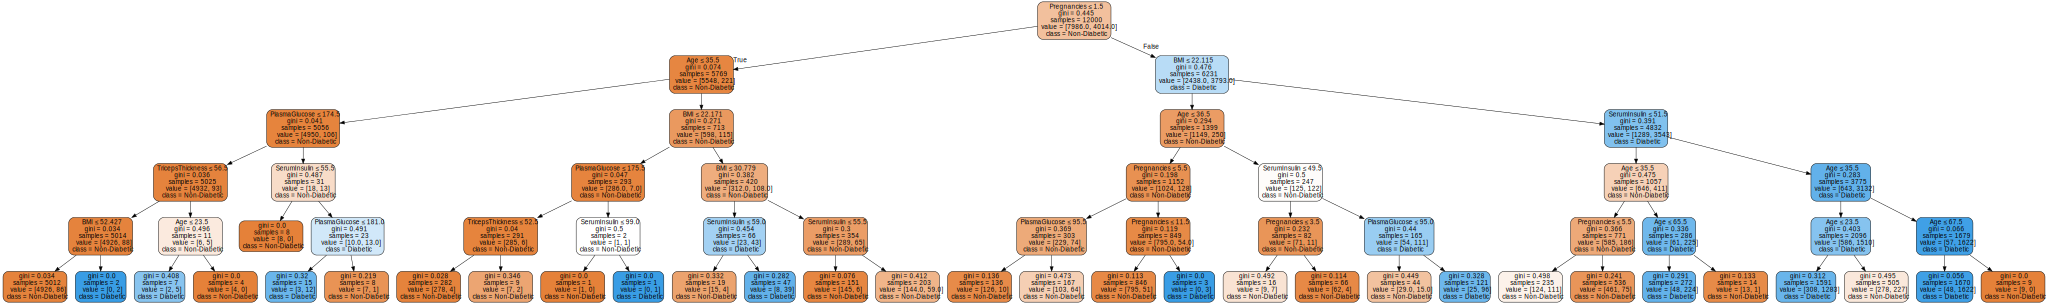

In [18]:
from sklearn.tree import export_graphviz
import graphviz

# Uncomment to visualize the decision tree (requires graphviz)
dot_data = export_graphviz(dt_classifier,
                            out_file=None,
                            feature_names=feature_columns,
                            class_names=['Non-Diabetic', 'Diabetic'],
                            filled=True,
                            rounded=True,
                            special_characters=True)
graph = graphviz.Source(dot_data)
graph

## 7. Hyperparameter Tuning

In [19]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 8, 10],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Setup grid search
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Show best parameters
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10}
Best Cross-Validation Score: 0.9141666666666666


## 8. Final Model and Evaluation

In [20]:
# Create final model with best parameters
final_model = DecisionTreeClassifier(
    criterion=grid_search.best_params_['criterion'],
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    random_state=42
)

# Train final model
final_model.fit(X_train, y_train)

# Evaluate on test set
y_pred_final = final_model.predict(X_test)
final_accuracy = (y_pred_final == y_test).sum() / len(y_test)
final_report = classification_report(y_test, y_pred_final)

print(f"Final Model Accuracy: {final_accuracy}")
print(f"\nFinal Classification Report:\n{final_report}")

Final Model Accuracy: 0.9053333333333333

Final Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2014
           1       0.88      0.83      0.85       986

    accuracy                           0.91      3000
   macro avg       0.90      0.89      0.89      3000
weighted avg       0.90      0.91      0.90      3000



In [21]:
import pickle

# Save the final model to a pickle file
with open('diabetes_decision_tree_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)

# To verify it saved correctly, you can load it back
with open('diabetes_decision_tree_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Verify the loaded model works the same
test_predictions = loaded_model.predict(X_test)
print(f"Loaded model accuracy: {(test_predictions == y_test).mean()}")

Loaded model accuracy: 0.9053333333333333


## 9. Conclusion

The decision tree model achieved an excellent accuracy of 90.5% on the test set after hyperparameter tuning, showing significant improvement over the initial model. The most important features for predicting diabetes were found to be PlasmaGlucose, BMI, and Age. The model performs well on both classes, with high precision and recall: 92% precision and 94% recall for non-diabetic patients (class 0), and 88% precision and 83% recall for diabetic patients (class 1). The high F1-scores (0.93 for class 0 and 0.85 for class 1) indicate a good balance between precision and recall. Overall, this model demonstrates strong predictive capability for diabetes classification and could be valuable in clinical screening applications.